In [34]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch


In [35]:
def calc_data_mean_std(
        root_path: str
        ) -> dict[str, tuple[float, float, float]]:

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    dataset = datasets.ImageFolder(root=root_path, transform=transform)

    dataloader = DataLoader(dataset, batch_size=64)

    mean = np.array([0.0, 0.0, 0.0])
    std = np.array([0.0, 0.0, 0.0])
    nb_samples = 0

    i = 0
    for data, _ in dataloader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0).numpy()
        std += data.std(2).sum(0).numpy()
        nb_samples += batch_samples
        i += 1
        if i == 10:
            break

    mean /= nb_samples
    std /= nb_samples

    return {
        "mean": mean.tolist(),
        "std": std.tolist()
    }


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# results = calc_data_mean_std("data")
# data_mean = results["mean"]
# data_std = results["std"]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
    )
test_data = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
    )

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


Device: cuda


In [37]:
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x, noise_level):
        noisy_x = x + noise_level * torch.randn_like(x)
        return self.model(noisy_x)


class EnhancedDiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, input_dim)
        self.relu = nn.ReLU()

    def forward(self, x, noise_level):
        x = self.relu(self.fc1(x + noise_level * torch.randn_like(x)))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        output = self.fc4(x)
        return output


In [38]:
def generate_image(model, start_noise_level=1.0, steps=10, input_dim=784):
    noise = torch.randn(1, input_dim).to(device)
    current_noise_level = start_noise_level

    with torch.no_grad():
        for step in range(steps):
            noise_level = current_noise_level * (steps - step - 1) / steps
            noise = model(noise, noise_level)

    generated_image = noise.view(28, 28).cpu().numpy()
    return generated_image


def display_generated_images(model, images_to_generate=5, input_dim=784):
    model.eval()
    plt.figure(figsize=(10, 2))
    for i in range(images_to_generate):
        generated_image = generate_image(model, input_dim=input_dim)
        plt.subplot(1, images_to_generate, i+1)
        plt.imshow(generated_image, cmap="gray")
        plt.axis("off")
    plt.show()
    model.train()


def train(
        model: nn.Module,
        data_loader,
        epochs=10,
        lr=0.001,
        show_images_progress=True,
        images_to_generate=5
        ):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        loss_history = []

        for _, (data, _) in enumerate(data_loader):
            data = data.view(data.size(0), -1).to(device)

            max_noise_level = epoch / epochs
            noise_level = np.random.uniform(0, max_noise_level)
            noisy_data = data + noise_level * torch.randn_like(data).to(device)

            optimizer.zero_grad()
            output = model(noisy_data, noise_level)
            loss = criterion(output, data)
            loss.backward()

            optimizer.step()

            loss_history.append(loss.item())

        torch.save(model, f"models/model_{epoch}.pth")

        loss_history = np.array(loss_history)
        print(f"Epoch {epoch+1}, Loss {np.mean(loss_history)}")
        
        if show_images_progress:
            display_generated_images(model, images_to_generate)


Epoch 1, Loss 0.16447529130811883


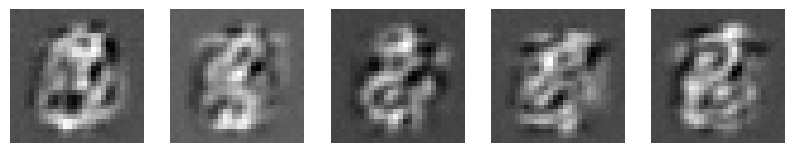

Epoch 2, Loss 0.07275667583256133


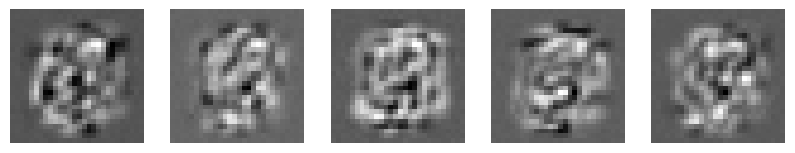

Epoch 3, Loss 0.05886041869455055


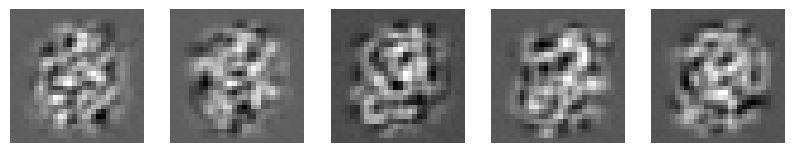

Epoch 4, Loss 0.051850463170359636


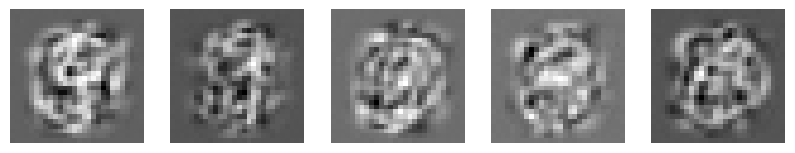

Epoch 5, Loss 0.0479669431562045


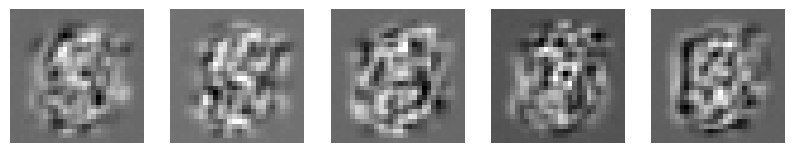

Epoch 6, Loss 0.04550089329274606


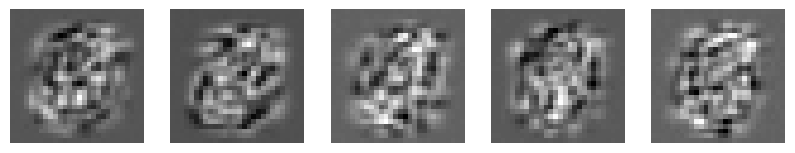

Epoch 7, Loss 0.04424988528463378


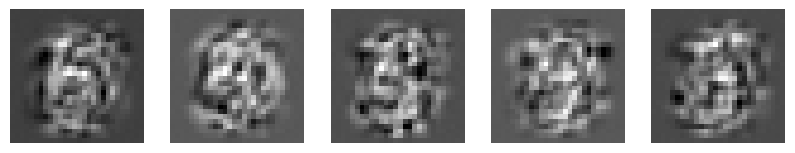

Epoch 8, Loss 0.043410358910780475


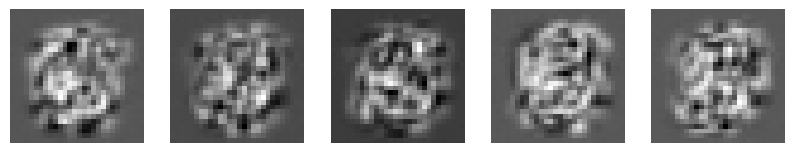

Epoch 9, Loss 0.043051758606328386


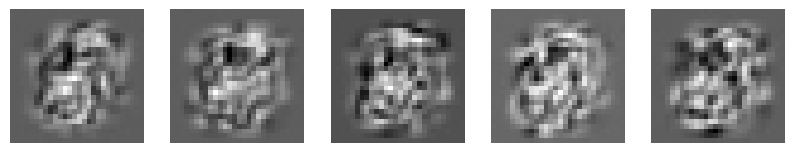

Epoch 10, Loss 0.04347094988374949


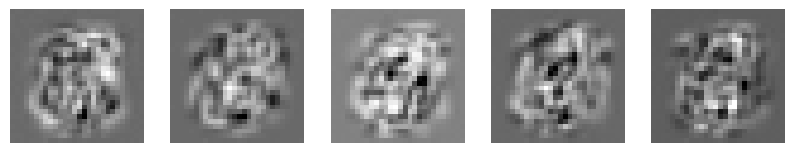

Epoch 11, Loss 0.04387016202817594


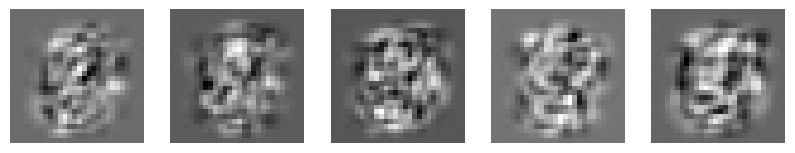

Epoch 12, Loss 0.04448283465305117


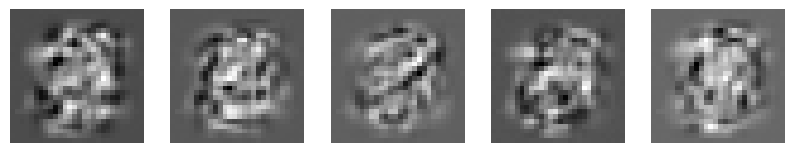

Epoch 13, Loss 0.04572255961867029


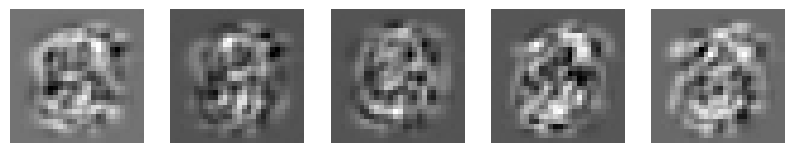

Epoch 14, Loss 0.04707445310694831


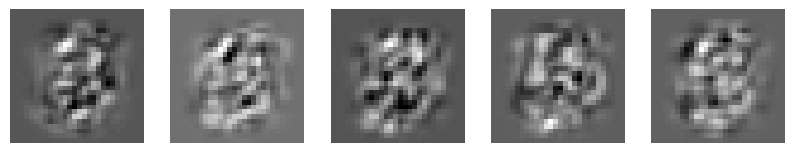

Epoch 15, Loss 0.04861510049766188


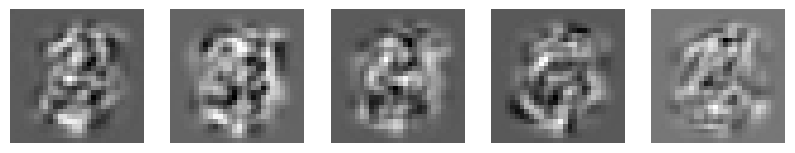

Epoch 16, Loss 0.05009585202359823


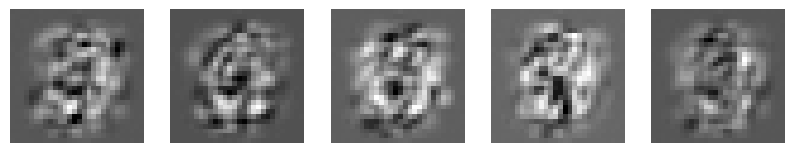

Epoch 17, Loss 0.05125081357655368


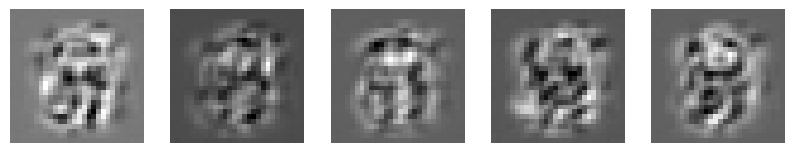

Epoch 18, Loss 0.05319901261486606


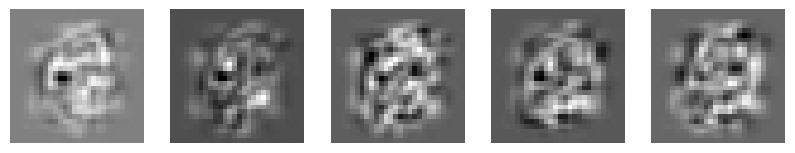

Epoch 19, Loss 0.05470351976896527


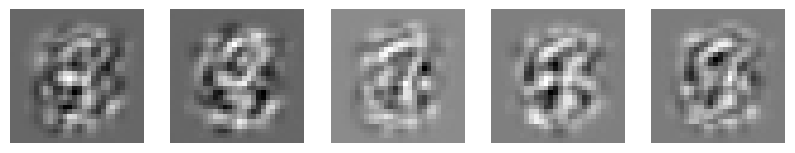

Epoch 20, Loss 0.057072320178564166


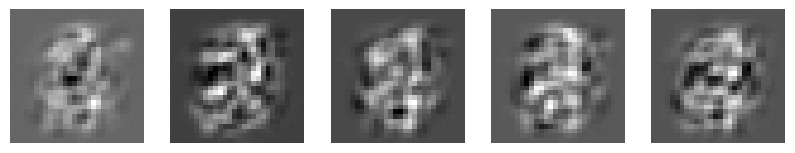

Epoch 21, Loss 0.059424597690545165


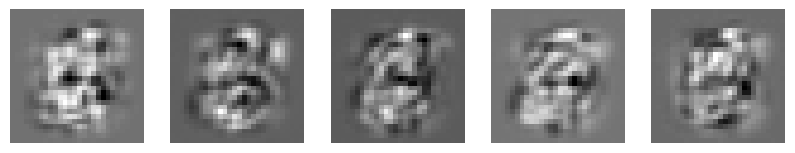

Epoch 22, Loss 0.06206642712817899


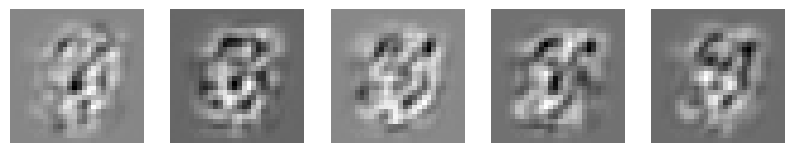

Epoch 23, Loss 0.06158393660762798


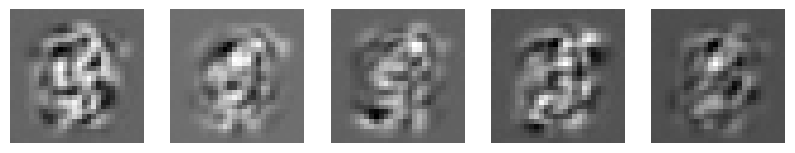

Epoch 24, Loss 0.06494784889333664


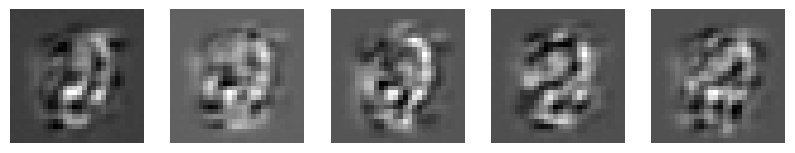

Epoch 25, Loss 0.06667049583405066


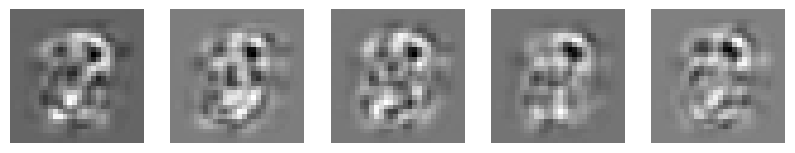

Epoch 26, Loss 0.06774116821412339


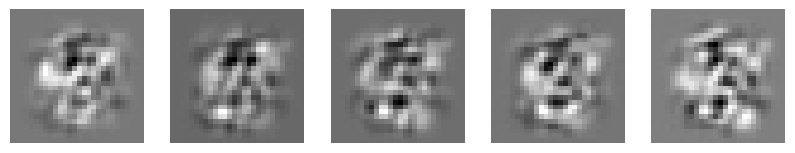

Epoch 27, Loss 0.06825145907493542


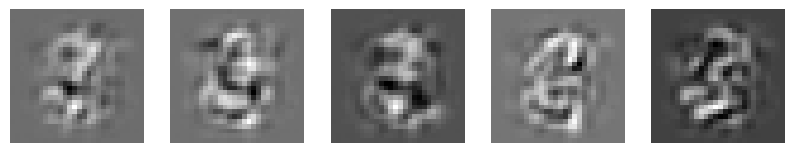

Epoch 28, Loss 0.06917575529135113


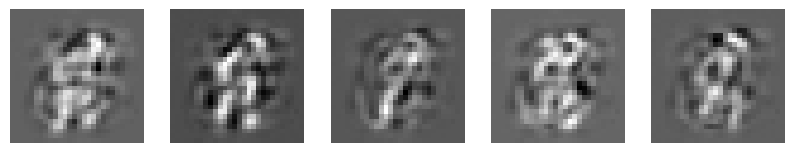

Epoch 29, Loss 0.06992938052187724


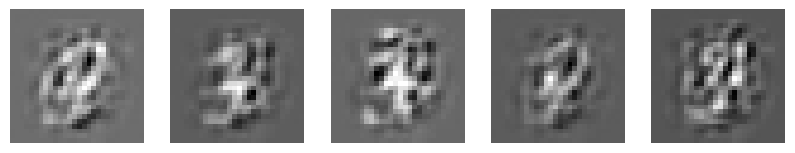

Epoch 30, Loss 0.072261385881761


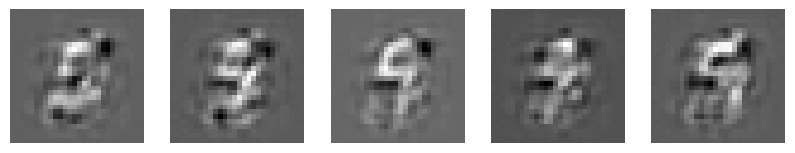

Epoch 31, Loss 0.07310386187136808


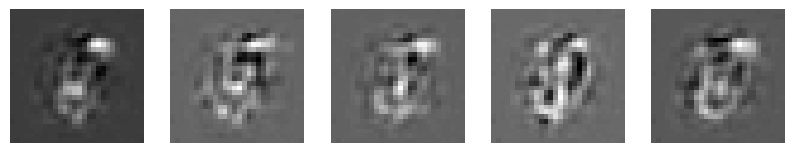

Epoch 32, Loss 0.07387801187871489


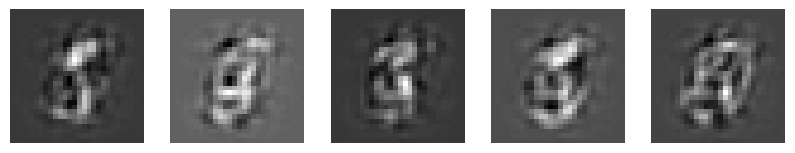

Epoch 33, Loss 0.07392186659580863


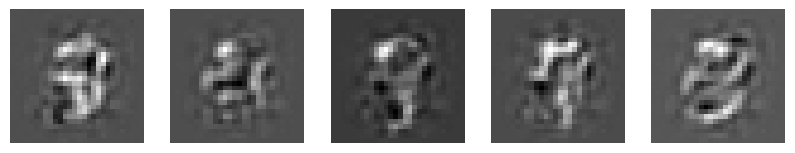

Epoch 34, Loss 0.07444882372231372


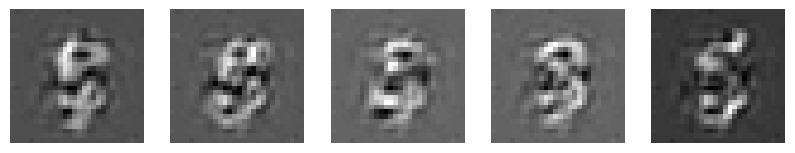

Epoch 35, Loss 0.07543808634458447


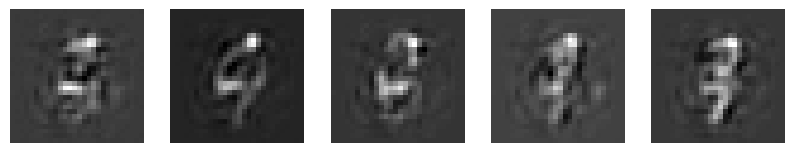

Epoch 36, Loss 0.07666697063203305


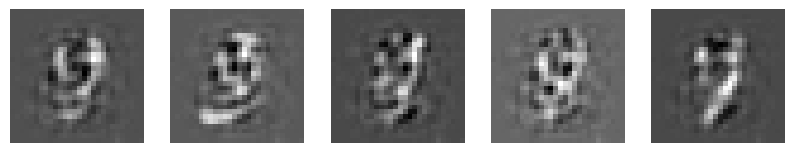

Epoch 37, Loss 0.07663790914200262


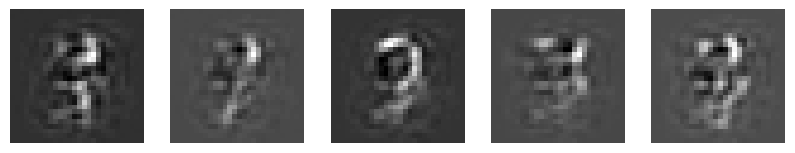

Epoch 38, Loss 0.07842235844622035


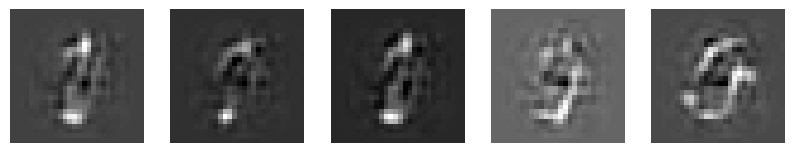

Epoch 39, Loss 0.07861384129457509


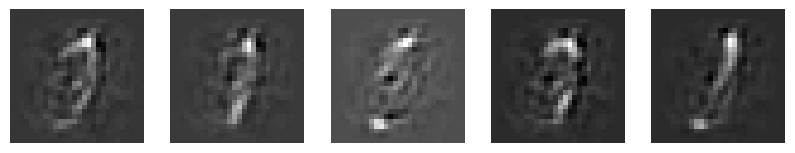

Epoch 40, Loss 0.07917049631619377


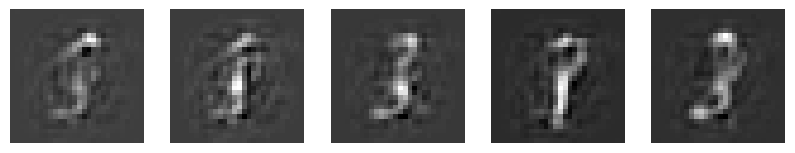

Epoch 41, Loss 0.07871126811673392


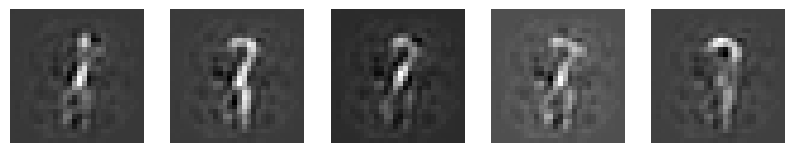

Epoch 42, Loss 0.08112378079277366


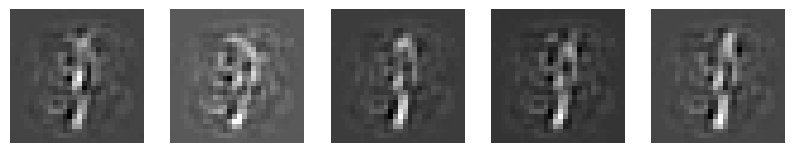

Epoch 43, Loss 0.08242973396534732


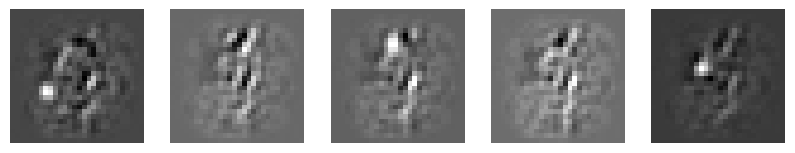

Epoch 44, Loss 0.08192132618715132


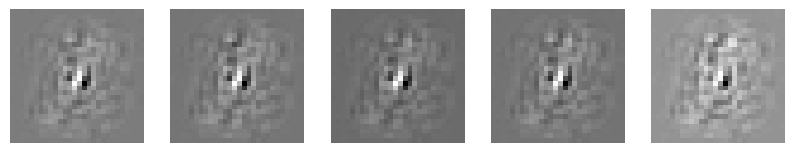

Epoch 45, Loss 0.08408760962916463


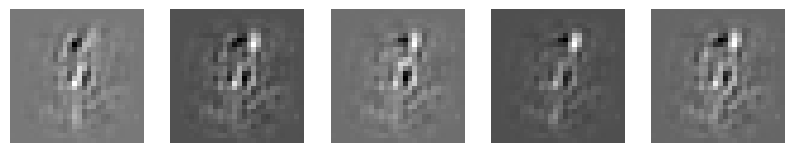

Epoch 46, Loss 0.08487833157848956


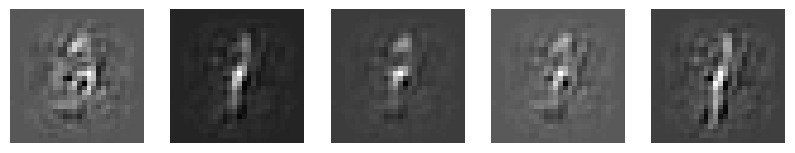

Epoch 47, Loss 0.08553808029971398


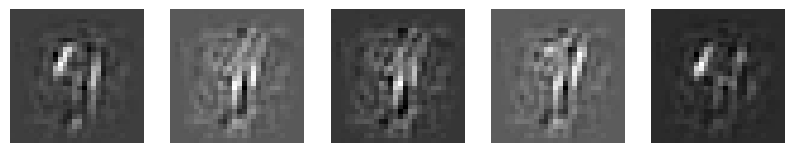

Epoch 48, Loss 0.0856278937087575


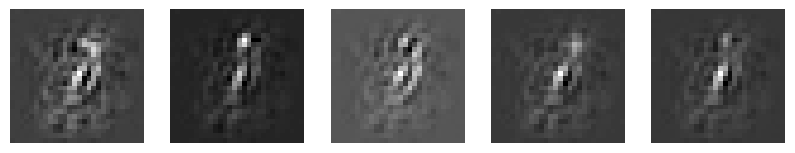

Epoch 49, Loss 0.08748343633388532


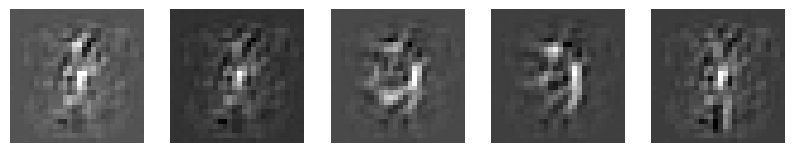

Epoch 50, Loss 0.09136471610222417


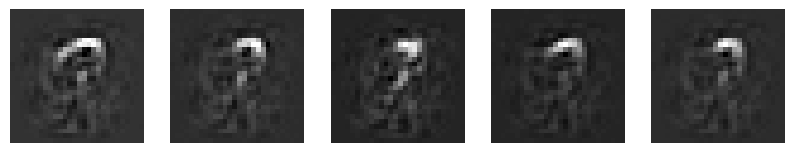

In [39]:
model = EnhancedDiffusionModel(input_dim=784).to(device)

train(model, train_loader, epochs=50)
